# Regresión Lineal Regularizada: Sesgo y Varianza
Por: Andrés Puente y Francisco Solano López-Bleda

## Cabeceras
Las librerías que usaremos a lo largo de la práctica

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import sys
import scipy.optimize as opt
#Para ignorar los warnings
import warnings
warnings.filterwarnings('ignore')

## Regresión lineal regularizada
En este primer apartado definimos las funciones para la regresión lineal y cargamos los datos de manera adecuada

In [2]:
def hipotesis(theta,X):
    return X.dot(theta)

def coste(thetas, matrizX, vectorY, _lambda=0.):
    nMuestras = matrizX.shape[0]
    hipo = hipotesis(thetas,matrizX).reshape((nMuestras,1))
    cost = float((1./(2*nMuestras)) * np.dot((hipo-vectorY).T,(hipo-vectorY))) + (float(_lambda)/(2*nMuestras)) * float(thetas[1:].T.dot(thetas[1:]))
    return cost 

def gradiente(thetas, matrizX, vectorY, _lambda=0.):
    thetas = thetas.reshape((thetas.shape[0],1))
    nMuestras = matrizX.shape[0]    
    grad = (1./float(nMuestras))*matrizX.T.dot(hipotesis(thetas,matrizX)-vectorY) + (float(_lambda)/nMuestras)*thetas
    return grad


### Simplificado

In [3]:
def gradiente_min(thetas, matrizX, vectorY, _lambda=0.):
    return gradiente(thetas, matrizX, vectorY, _lambda=0.).flatten()

def optimizarTheta(thetas, matrizX, vectorY, _lambda=0.,_print=True):
    return opt.fmin_cg(coste,x0=thetas,fprime=gradiente_min, args=(matrizX,vectorY,_lambda),disp=_print, epsilon=1.49e-12, maxiter=1000)


### Procedimiento
Una vez definidas todas las funciones necesarias, procedemos a cargar y ejecutar los datos

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 18
         Function evaluations: 28
         Gradient evaluations: 28


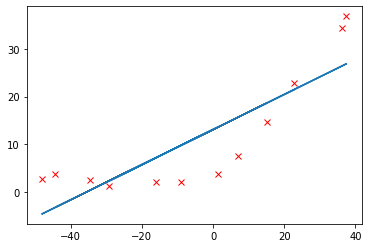

In [4]:
data = loadmat('ex5data1.mat')
y = data['y']
X = data['X']

yval = data['yval']
Xval = data['Xval']

ytest = data['ytest']
Xtest = data['Xtest']

X_unos = np.insert(X,0,1,axis=1)
Xval = np.insert(Xval,0,1,axis=1)
Xtest=np.insert(Xtest,0,1,axis=1)

plt.figure()
plt.plot(X,y,'rx')

Theta = np.ones((2,1))
theta_opt = optimizarTheta(Theta,X_unos,y,0.)
plt.plot(X,hipotesis(theta_opt,X_unos).flatten())
plt.show()

## Curvas de aprendizaje
### Introducción
Utilizaremos curvas de aprendizaje para localizar el posible sobreajuste o subajuste, para ello usaremos la hipótesis de regresión lineal en diferentes subconjuntos de la muestra
### Definición de funciones

In [5]:
def curva_aprendizaje():    
    theta = np.ones((2,1))
    muestras, trainVector, valVector = [], [], []
    for x in range(1,13,1):
        train_aux = X_unos[:x,:] #vamos seleccionando primer conjunto entrenamiento, luego segundo...
        y_aux = y[:x]        
        fit_theta = optimizarTheta(theta,train_aux,y_aux,_lambda=0.,_print=False)
        trainVector.append(coste(fit_theta,train_aux,y_aux,_lambda=0.))
        valVector.append(coste(fit_theta, Xval, yval,_lambda=0.))
        muestras.append(y_aux.shape[0])

    return trainVector, valVector, muestras

def dibuja_curva_aprendizaje(vector_train, vector_val, nMuestras): 
    plt.figure()
    plt.plot(nMuestras, vector_train, label='Train')
    plt.plot(nMuestras, vector_val, label='Cross Validation')
    plt.legend()
    plt.title('Learning curve for linear regression')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')    
    plt.show()

### Procedimiento

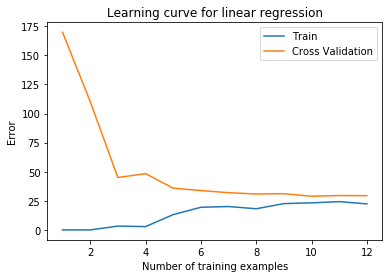

In [6]:
train_vec, val_vec, cont = curva_aprendizaje()
dibuja_curva_aprendizaje(train_vec, val_vec, cont)

## Regresión polinomial
Para poder Resolver el problema anterior vamos a cambiar la hipótesis por un polinomio de grado variable por código para que asi se adapte mejor a este entrenamiento.
### Definición de funciones

In [7]:
# Recibe una matriz X (dimensiones m*l) y devuelve otra con dimensiones m*p
def generar_dimension(matrizX, p):    
    for i in range(p):
        dim = i+2
        matrizX = np.insert(matrizX,matrizX.shape[1],np.power(matrizX[:,1],dim),axis=1)
    return matrizX

#Funcion para evitar grandes diferencias de rango
def normalizar_atributos(matrizX):    
    medias = np.mean(matrizX,axis=0) 
    matrizX[:,1:] = matrizX[:,1:] - medias[1:]
    desviaciones = np.std(matrizX,axis=0,ddof=1)
    matrizX[:,1:] = matrizX[:,1:] / desviaciones[1:]
    return matrizX, medias, desviaciones #MatrizX esta normalizada

def hipotesis_polinomial(thetas, medias, desviaciones):    
    puntos = 50
    xvals = np.linspace(-55,55,puntos)
    xmat = np.ones((puntos,1))
    
    xmat = np.insert(xmat, xmat.shape[1],xvals.T,axis=1)
    xmat = generar_dimension(xmat,len(thetas)-2)
    
    xmat[:,1:] = xmat[:,1:] - medias[1:]
    xmat[:,1:] = xmat[:,1:] / desviaciones[1:]
    
    plt.figure()
    plt.plot(X, y,'rx')
    plt.plot(xvals,hipotesis(thetas, xmat),'b--')
    plt.show()
    
# Dibujado y cálculo de curvas de aprendizaje
def dibuja_curva_aprendizaje_polinomio(_lamb=0.):
    thetas = np.ones((grado_polinomio+2, 1))
    muestras, vector_train, vector_val = [], [], []
    matrizXval, aux1, aux2 = normalizar_atributos(generar_dimension(Xval, grado_polinomio))

    for x in range(1,13,1):
        train_aux = X_unos[:x,:]
        y_aux = y[:x]
        muestras.append(y_aux.shape[0])
        train_aux = generar_dimension(train_aux, grado_polinomio)   
        train_aux, aux1, aux2 = normalizar_atributos(train_aux)
        theta_opt = optimizarTheta(thetas, train_aux, y_aux,_lambda=_lamb, _print=False)
        vector_train.append(coste(theta_opt, train_aux, y_aux,_lambda=_lamb))
        vector_val.append(coste(theta_opt, matrizXval, yval, _lambda=_lamb))
        
    plt.figure()
    plt.plot(muestras, vector_train, label='Train')
    plt.plot(muestras, vector_val, label='Cross Validation')
    plt.legend()
    plt.title('Polynomial Regression Learning Curve (lambda = ' + str(_lamb) + ')')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.ylim([0,100])
    plt.show()

### Procedimiento

         Current function value: 0.025614
         Iterations: 1000
         Function evaluations: 2026
         Gradient evaluations: 2026


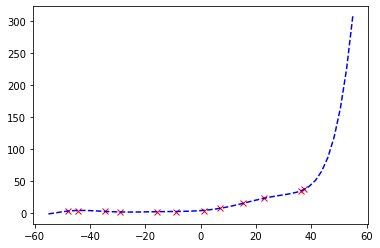

In [8]:
# Dibujado de hipótesis polinomial
grado_polinomio = 8
X_poli = generar_dimension(X_unos,grado_polinomio)
X_poli_norm, media, desviacion = normalizar_atributos(X_poli)
Theta = np.ones((X_poli_norm.shape[1],1))
theta_opt = optimizarTheta(Theta, X_poli_norm, y, 0.)
hipotesis_polinomial(theta_opt, media, desviacion)

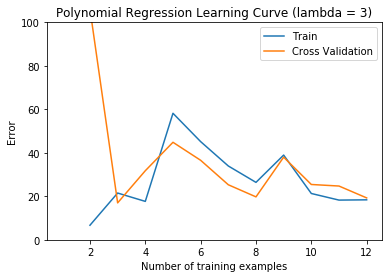

In [9]:
#Representar curvas de aprendizaje
dibuja_curva_aprendizaje_polinomio(3)

## Selección de Lambda
Procedemos a usar diferentes valores de Lambda para poder generar una gráfica de error
### Definición de funciones

In [10]:
def try_lambda_values(maxLambda,numSteps):
    Theta = np.zeros((X_poli_norm.shape[1],1))
    lambdas = np.linspace(0,maxLambda,numSteps)
    vector_train, vector_val = [], []
    for lamb in lambdas:
        train_aux = generar_dimension(X_unos, grado_polinomio)
        train_aux_norm, aux1, aux2 = normalizar_atributos(train_aux)
        val_aux = generar_dimension(Xval, grado_polinomio)
        val_aux_norm, aux1, aux2 = normalizar_atributos(val_aux)
        ini_theta = np.ones((X_poli_norm.shape[1],1))
        theta_opt = optimizarTheta(Theta, train_aux_norm, y, lamb, False)
        vector_train.append(coste(theta_opt, train_aux_norm, y, _lambda=lamb))
        vector_val.append(coste(theta_opt, val_aux_norm, yval, _lambda=lamb))
    plt.figure()
    plt.plot(lambdas, vector_train, label='Train')
    plt.plot(lambdas, vector_val, label='Cross Validation')
    plt.legend()
    plt.xlabel('lambda')
    plt.ylabel('Error')
    plt.show()


### Procedimiento

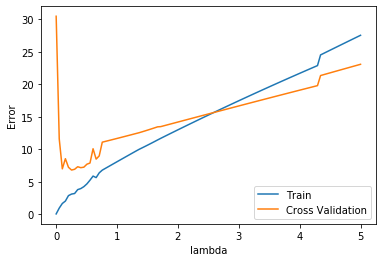

In [11]:
try_lambda_values(5,100)